<a href="https://colab.research.google.com/github/ethandsz/GTSRB-Classification-Localization/blob/main/Localization%26Classification_TrafficKeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [38]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score

np.random.seed(42)

In [39]:
# Label Overview
labels = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

In [40]:
%cd gdrive/MyDrive/Traffic/

[Errno 2] No such file or directory: 'gdrive/MyDrive/Traffic/'
/content/gdrive/MyDrive/Traffic


In [41]:
%ls

'archive (2).zip'      test/
 cifar10-resnet9.pth   Test/
 gfg.png               Test.csv
 image.jpg             traffic-keras.h5
 image.png             _traffic-signs-in-germany_03748545_detail.jpg
 meta/                 train/
 Meta/                 Train/
 Meta.csv              Train.csv
 ResNet-Traffic.pth


In [46]:
train_path = './Train'
test_path = './Test'

IMG_HEIGHT = 32
IMG_WIDTH = 32
channels = 3

In [47]:
classes = './Train'
#print(os.listdir(classes))
classes = os.listdir(classes)
classes
NUM_CATEGORIES = len(classes)

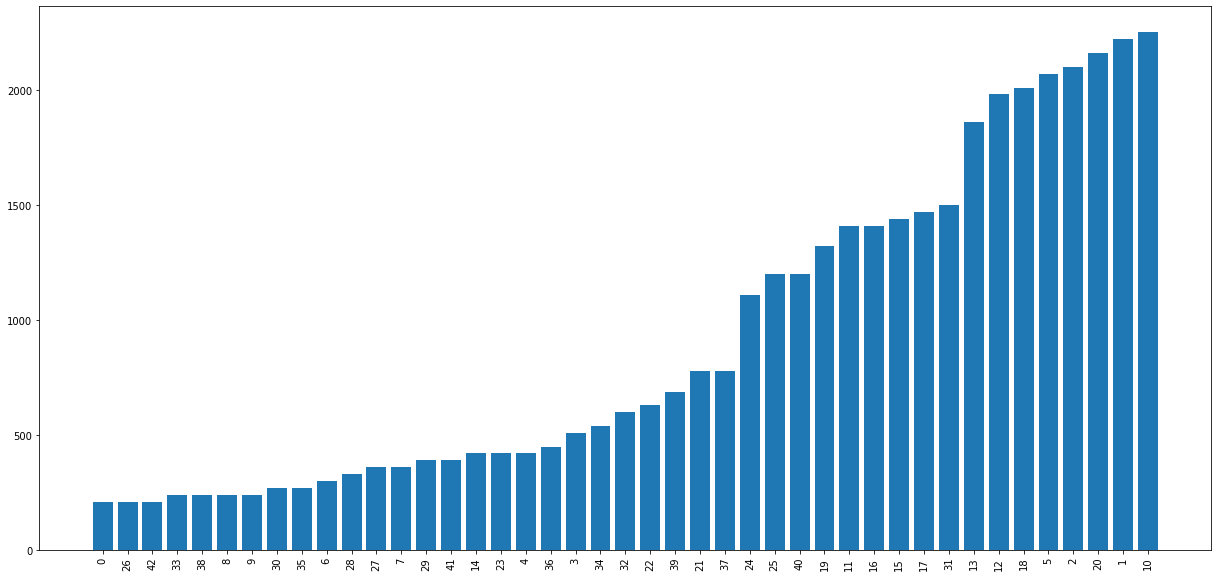

In [44]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

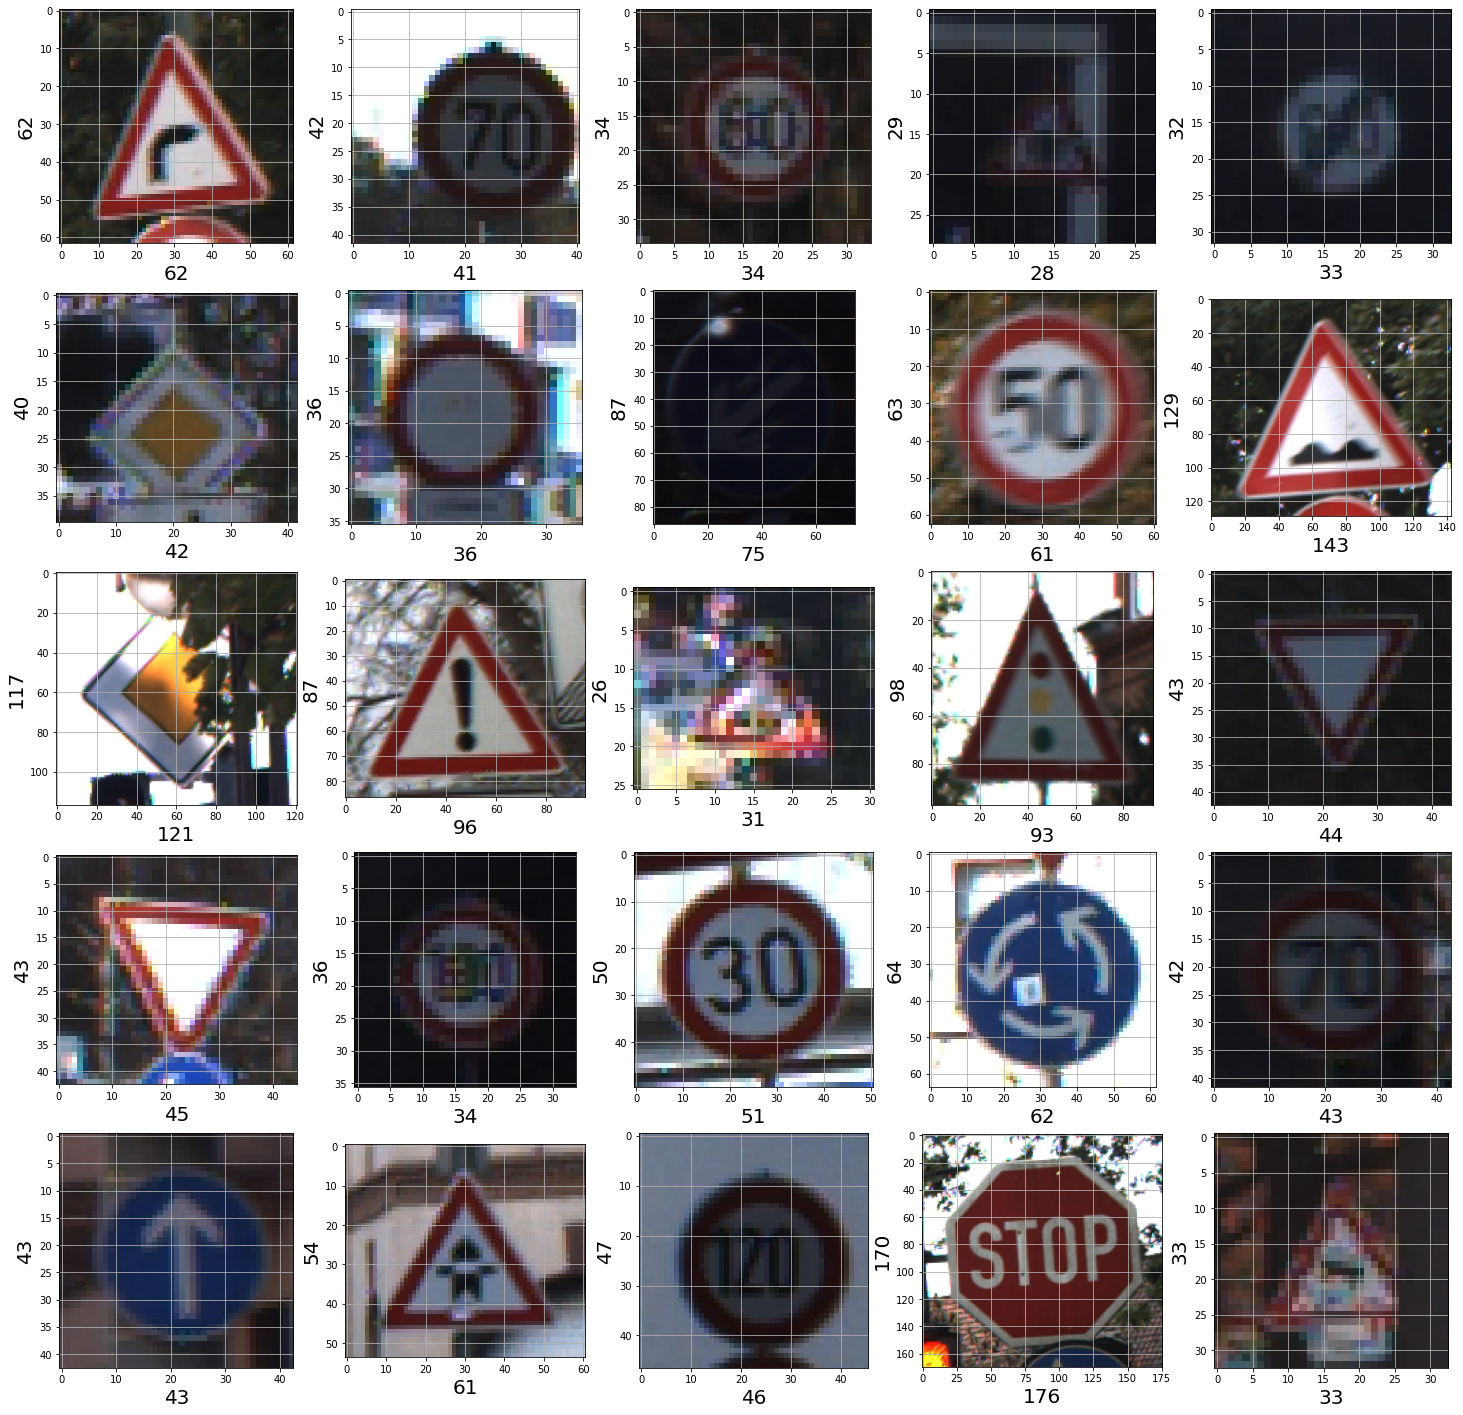

In [10]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread

test = pd.read_csv('Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path ='./' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(b=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

Test/06567.png


<Figure size 432x432 with 0 Axes>

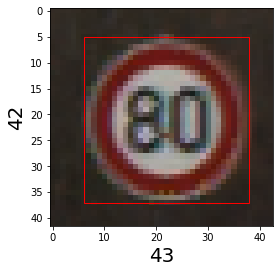

In [471]:
import random
from matplotlib.image import imread
import matplotlib.patches as patches
import matplotlib.image as mpimg



test = pd.read_csv('Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(6,6))


fig, ax = plt.subplots()

#plt.show()

random_img_path ='./' + random.choice(imgs)
rand_img = imread(random_img_path)
#rand_img = rand_img.resize((64,64))
plt.imshow(rand_img)
plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

x1 = test.loc[test['Path'] == random_img_path[2:]]["Roi.X1"].item()
x2 = test.loc[test['Path'] == random_img_path[2:]]["Roi.X2"].item()
y1 = test.loc[test['Path'] == random_img_path[2:]]["Roi.Y1"].item()
y2 = test.loc[test['Path'] == random_img_path[2:]]["Roi.Y2"].item()

height = test.loc[test['Path'] == random_img_path[2:]]["Height"].item()
width = test.loc[test['Path'] == random_img_path[2:]]["Width"].item()


rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

print(random_img_path[2:])

check = test.loc[test['Path'] == random_img_path[2:]]


In [106]:
%%time
image_data = []
image_labels = []
image_locations = []

train = pd.read_csv('Train.csv')

for i in range(NUM_CATEGORIES):
    path = './Train/' + str(i)
    images = os.listdir(path)
    count = 0
    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)

            img_path = path + "/" + img

            height = train.loc[train['Path'] == img_path[2:]]["Height"].item()
            width = train.loc[train['Path'] == img_path[2:]]["Width"].item()

            x1 = train.loc[train['Path'] == img_path[2:]]["Roi.X1"].item() * (IMG_WIDTH/width)
            x2 = train.loc[train['Path'] == img_path[2:]]["Roi.X2"].item() * (IMG_WIDTH/width)
            y1 = train.loc[train['Path'] == img_path[2:]]["Roi.Y1"].item() * (IMG_HEIGHT/height)
            y2 = train.loc[train['Path'] == img_path[2:]]["Roi.Y2"].item() * (IMG_HEIGHT/height)

            image_locations.append((x1,x2,y1,y2))
        except:
            print("Error in " + img)
        count = count + 1
        if(count == 750):
          break
    if(i%5==0):
      print(i)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)
image_locations = np.array(image_locations)
print(image_data.shape, image_labels.shape)
print(img_path)

0
5
10
15
20
25
30
35
40
(23189, 32, 32, 3) (23189,)
./Train/42/00042_00001_00013.png
CPU times: user 6min 3s, sys: 6.02 s, total: 6min 9s
Wall time: 7min 5s


In [107]:
image_labels

array([ 0,  0,  0, ..., 42, 42, 42])

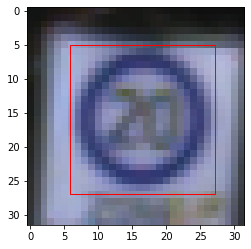

In [146]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
i = random.randint(0,30)

plt.imshow(image_data[i], interpolation='nearest')
x1 = image_locations[i][0]
x2 = image_locations[i][1]
y1 = image_locations[i][2]
y2 = image_locations[i][3]

rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.show()


In [109]:
train_data, val_data, train_label, val_label, train_locations, val_locations = train_test_split(image_data, image_labels, image_locations, test_size=0.3, random_state=42, shuffle=True)

train_data = train_data/255 
val_data = val_data/255

print("traindata.shape", train_data.shape)
print("validdata.shape", val_data.shape)
print("trainlabel.shape", train_label.shape)
print("validlabel.shape", val_label.shape)
print("Train locations.shape ",train_locations.shape)
print("ValLocation.shape ",val_locations.shape)

traindata.shape (16232, 32, 32, 3)
validdata.shape (6957, 32, 32, 3)
trainlabel.shape (16232,)
validlabel.shape (6957,)
Train locations.shape  (16232, 4)
ValLocation.shape  (6957, 4)


In [110]:
train_label = keras.utils.to_categorical(train_label, NUM_CATEGORIES)
val_label = keras.utils.to_categorical(val_label, NUM_CATEGORIES)

print(train_label.shape)
print(val_label.shape)

(16232, 43)
(6957, 43)


In [111]:
train_label

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [112]:
trainTargets = {
    "cl_head": train_label,
    "bb_head": train_locations
}
validationTargets = {
    "cl_head": val_label,
    "bb_head": val_locations
}

In [113]:
len(val_locations[3])

4

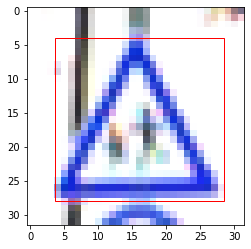

In [114]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
i = random.randint(0,30)
x1 = train_locations[i][0]
x2 = train_locations[i][1]

y1 = train_locations[i][2]
y2 = train_locations[i][3]

rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.imshow(train_data[i], interpolation='nearest')
plt.show()

In [265]:
class Sharpen(tf.keras.layers.Layer):
  """
  Sharpen layer sharpens the edges of the image.
  """
  def __init__(self, num_outputs):
    super(Sharpen, self).__init__()
    self.num_outputs = num_outputs

  def build(self, input_shape):
    self.kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    self.kernel = tf.expand_dims(self.kernel, 0)
    self.kernel = tf.expand_dims(self.kernel, 0)
    self.kernel = tf.cast(self.kernel, tf.float32)

  def call(self, input_) :
    return tf.nn.conv2d(input_, self.kernel, strides=[1, 1, 1, 1], padding='SAME')

In [282]:
from keras import backend as K
K.set_image_data_format('channels_first')


In [376]:
input_shape = (IMG_HEIGHT,IMG_WIDTH,3)
input_layer = keras.layers.Input(input_shape)

###---OG---###
# base_layers = keras.layers.experimental.preprocessing.Rescaling(1./255)(input_layer)

# base_layers = keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu',padding='same',name='bl_1')(base_layers)
# base_layers = keras.layers.BatchNormalization(axis=-1,name='bl_2')(base_layers)
# base_layers = keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu',padding='same',name='bl_3')(base_layers)
# base_layers = keras.layers.BatchNormalization(axis=-1,name='bl_4')(base_layers)
# base_layers = keras.layers.MaxPool2D(pool_size=(2, 2),padding='same',name='bl_5')(base_layers)

# base_layers = keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu',padding='same',name='bl_6')(base_layers)
# base_layers = keras.layers.BatchNormalization(axis=-1,name='bl_7')(base_layers)
# base_layers = keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu',padding='same',name='bl_8')(base_layers)
# base_layers = keras.layers.BatchNormalization(axis=-1,name='bl_9')(base_layers)

# base_layers = keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu',padding='same',name='bl_10')(base_layers)
# base_layers = keras.layers.BatchNormalization(axis=-1,name='bl_11')(base_layers)
# base_layers = keras.layers.MaxPool2D(pool_size=(2, 2),padding='same',name='bl_12')(base_layers)

# base_layers = keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu',padding='same',name='bl_13')(base_layers)
# base_layers = keras.layers.BatchNormalization(axis=-1,name='bl_14')(base_layers)
# base_layers = keras.layers.MaxPool2D(pool_size=(2, 2),padding='same',name='bl_15')(base_layers)

# base_layers = keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu',padding='same',name='bl_16')(base_layers)
# base_layers = keras.layers.BatchNormalization(axis=-1,name='bl_17')(base_layers)
# base_layers = keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu',padding='same',name='bl_18')(base_layers)
# base_layers = keras.layers.BatchNormalization(axis=-1,name='bl_19')(base_layers)

# base_layers = keras.layers.MaxPool2D(pool_size=(4, 4),padding='same',name='bl_20')(base_layers)
# base_layers = keras.layers.Flatten(name='bl_21')(base_layers)
# base_layers = keras.layers.Dropout(rate=0.5,name='bl_22')(base_layers)


# classifier_branch = keras.layers.Dense(512, activation='relu',name='cl_1')(base_layers)
# classifier_branch = keras.layers.Dense(256, activation='relu',name='cl_2')(classifier_branch)
# classifier_branch = keras.layers.Dense(128, activation='relu',name='cl_3')(classifier_branch)
# classifier_branch = keras.layers.Dense(64, activation='relu',name='cl_4')(classifier_branch)
# classifier_branch = keras.layers.Dense(43, activation='softmax', name='cl_head')(classifier_branch)

# locator_branch = keras.layers.Dense(512, activation='relu',name='bb_1')(base_layers)
# locator_branch = keras.layers.Dense(256, activation='relu',name='bb_2')(locator_branch)
# locator_branch = keras.layers.Dense(128, activation='relu',name='bb_3')(locator_branch)
# locator_branch = keras.layers.Dense(64, activation='relu',name='bb_4')(locator_branch)
# locator_branch = keras.layers.Dense(32, activation='relu',name='bb_5')(locator_branch)
# locator_branch = keras.layers.Dense(4, activation='softmax', name='bb_head')(locator_branch)

###--TEST---###
base_layers = keras.layers.experimental.preprocessing.Rescaling(1./255, name='bl_1')(input_layer)
base_layers = Sharpen(num_outputs=(IMG_HEIGHT, IMG_WIDTH, 3))(base_layers)
base_layers = keras.layers.Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', name='bl_2')(base_layers)
base_layers = keras.layers.Conv2D(filters=64, kernel_size=(3,3),padding='same', activation='relu', name='bl_3')(base_layers)
base_layers = keras.layers.MaxPool2D(pool_size=(2,2), name = "bl_4")(base_layers)
base_layers = keras.layers.Dropout(rate=0.25,name='bl_5')(base_layers)
base_layers = keras.layers.Conv2D(filters=64, kernel_size=(3,3),padding='same', activation='relu', name='bl_6')(base_layers)
#base_layers = keras.layers.MaxPool2D(pool_size=(1,1), name = "bl_7")(base_layers)
base_layers = keras.layers.Dropout(rate=0.25,name='bl_8')(base_layers)
base_layers = keras.layers.Flatten(name='bl_9')(base_layers)
classifier_branch = keras.layers.Dense(256, activation='softmax', name='bl_10')(base_layers)
base_layers = keras.layers.Dropout(rate=0.50,name='bl_11')(base_layers)

classifier_branch = keras.layers.Dense(43, activation='softmax', name='cl_head')(base_layers)

locator_branch = keras.layers.Dense(4, activation='linear', name='bb_head')(base_layers)



In [377]:
model = tf.keras.Model(input_layer,
           outputs=[classifier_branch, locator_branch])

In [378]:
losses = {"cl_head":tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
   "bb_head":tf.keras.losses.MSE}

In [379]:
model.compile(loss=losses, optimizer=Adam(lr=0.01), metrics=['accuracy'])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [380]:
history = model.fit(train_data, trainTargets,
             validation_data=(val_data, validationTargets),
             batch_size=16,
             epochs=50,
             shuffle=True,
             verbose = 1)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1015/1015 [==============================] - 7s 6ms/step - loss: 11.1118 - cl_head_loss: 4.6138 - bb_head_loss: 6.4980 - cl_head_accuracy: 0.0292 - bb_head_accuracy: 0.5005 - val_loss: 5.2492 - val_cl_head_loss: 3.8592 - val_bb_head_loss: 1.3900 - val_cl_head_accuracy: 0.0351 - val_bb_head_accuracy: 0.5912
Epoch 2/50
1015/1015 [==============================] - 6s 6ms/step - loss: 7.0006 - cl_head_loss: 3.9880 - bb_head_loss: 3.0126 - cl_head_accuracy: 0.0421 - bb_head_accuracy: 0.5040 - val_loss: 4.9217 - val_cl_head_loss: 3.4583 - val_bb_head_loss: 1.4634 - val_cl_head_accuracy: 0.0970 - val_bb_head_accuracy: 0.5104
Epoch 3/50
1015/1015 [==============================] - 6s 6ms/step - loss: 6.4221 - cl_head_loss: 3.5413 - bb_head_loss: 2.8808 - cl_head_accuracy: 0.0829 - bb_head_accuracy: 0.5285 - val_loss: 4.0801 - val_cl_head_loss: 2.9640 - val_bb_head_loss: 1.1161 - val_cl_head_accuracy: 0.1417 - val_bb_head_accuracy: 0.5706
Epoch 4/50
1015/1015 [==============================] - 

No entry
[[ 4.4568477 27.755068   4.5816846 27.728004 ]]


<Figure size 432x432 with 0 Axes>

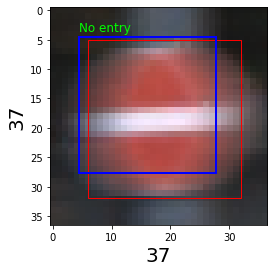

In [470]:
import random
from matplotlib.image import imread
import matplotlib.patches as patches
import matplotlib.image as mpimg
import cv2


test = pd.read_csv('Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(6,6))


fig, ax = plt.subplots()

#plt.show()

random_img_path ='./' + random.choice(imgs)
rand_img = imread(random_img_path)
plt.imshow(rand_img)
new_array = cv2.resize(rand_img, (IMG_WIDTH, IMG_HEIGHT))
new_array = new_array.reshape(-1, IMG_WIDTH, IMG_HEIGHT, 3)
pred = model.predict(new_array)


plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

x1 = test.loc[test['Path'] == random_img_path[2:]]["Roi.X1"].item()
x2 = test.loc[test['Path'] == random_img_path[2:]]["Roi.X2"].item()
y1 = test.loc[test['Path'] == random_img_path[2:]]["Roi.Y1"].item()
y2 = test.loc[test['Path'] == random_img_path[2:]]["Roi.Y2"].item()

height = test.loc[test['Path'] == random_img_path[2:]]["Height"].item()
width = test.loc[test['Path'] == random_img_path[2:]]["Width"].item()


rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

classes_x=np.argmax(pred[0],axis=1)
print(labels[int(classes_x)])
print(pred[1])
pred_x1 = pred[1][0][0]
pred_x2 = pred[1][0][1]
pred_y1 = pred[1][0][2]
pred_y2 = pred[1][0][3]

text = plt.text(pred_x1, pred_y1-1, labels[int(classes_x)], fontsize=12, color = 'lime')

rect = patches.Rectangle((pred_x1, pred_y1), pred_x2-pred_x1, pred_y2-pred_y1, linewidth=2, edgecolor='b', facecolor='none')
ax.add_patch(rect)

In [311]:
pred[1][0]

array([ 3.325045, 29.493382,  3.39827 , 29.476494], dtype=float32)

[33]
Turn right ahead


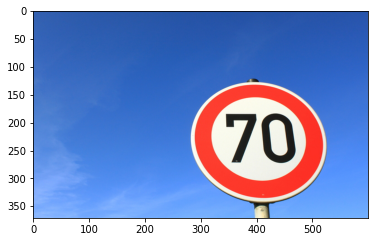

In [456]:
data = []
image = cv2.imread("_traffic-signs-in-germany_03748545_detail.jpg")
image_fromarray = Image.fromarray(image, 'RGB')
resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
data.append(np.array(resize_image))
X_test = np.array(data)
X_test = X_test/255
predict_x=model.predict(X_test) 
classes_x=np.argmax(predict_x[0],axis=1)
print((classes_x))
print(labels[int(classes_x)])
showimg = mpimg.imread("_traffic-signs-in-germany_03748545_detail.jpg", 0)
fig, ax = plt.subplots(1)
ax.imshow(showimg)
plt.show()

Stop
[[-83.853424 107.97925  -74.100334  99.77404 ]]


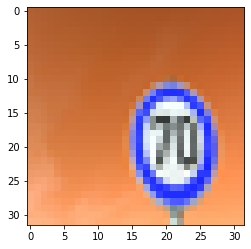

In [457]:
from numpy import asarray

image = cv2.imread("_traffic-signs-in-germany_03748545_detail.jpg")
image_fromarray = Image.fromarray(image, 'RGB')
resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
numpydata = asarray(resize_image)
new_array = cv2.resize(numpydata, (IMG_WIDTH, IMG_HEIGHT))
new_array = new_array.reshape(-1, IMG_WIDTH, IMG_HEIGHT, 3)
pred = model.predict(new_array)
fig, ax = plt.subplots()
plt.imshow(numpydata, interpolation='nearest')

classes_x=np.argmax(pred[0],axis=1)
print(labels[int(classes_x)])
print(pred[1])
pred_x1 = pred[1][0][0]
pred_x2 = pred[1][0][1]
pred_y1 = pred[1][0][2]
pred_y2 = pred[1][0][3]

#text = plt.text(pred_x1, pred_y1-1, labels[int(classes_x)], fontsize=12, color = 'lime')

rect = patches.Rectangle((pred_x1, pred_y1), pred_x2-pred_x1, pred_y2-pred_y1, linewidth=2, edgecolor='b', facecolor='none')
ax.add_patch(rect)
